# Covariance for Angular Power Spectra with *Heracles*

This notebook demonstrates how *Heracles* computes an estimate of the covariance of the two-point statistics from a 3×2pt catalogue using the DICES method. This tutorial is heavily based on the summary statisitcs tutorial so we will reproduce the results found in said tutorial without going into the details of the analysis. We will then show how to compute the covariance of the angular power spectra using *Heracles*.

<div class="alert alert-info">

**Important note**

This notebook is only meant to give you an idea of **how *Heracles* works**.

It does **not** show everything that *Heracles* can do.

**This is a toy, treat it is such!**

</div>

## Setup

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
import heracles
import heracles.healpy
from heracles.notebook import Progress
# Covariance code
import heracles.dices as dices

import helpers

with Progress("example data") as progress:
    helpers.get_example_data(progress)

VBox()

## Basic parameters

This is the resolution parameter for measuring spectra from *HEALPix* maps.  Here, we use `nside = 1024` since that is the resolution at which the example data has been created. A value `lmax` of approximate 1.5x `nside` is fairly safe in terms of errors introduced by *HEALPix*.

In [2]:
nside = 128
lmax = 150
nbins = 3

## Prepare maps

*Heracles* provides a flexible interface for loading catalogues from FITS files or arrays. It also provides a base class that can quickly be extended, e.g., to databases or more.

Here we use the FITS interface to read a catalogue from file. We could specify the columns to read, but the example catalogue does not have much more than we need here.

Importantly, catalogues are never read into memory all at once. Their `page_size` attribute determines how many rows are read at a time.

In [3]:
data_maps = heracles.read_maps("example-data_maps.fits")

In [4]:
data_maps = heracles.read_maps("example-data_maps.fits")
for key in list(data_maps.keys()):
    f, i = key
    if i <= nbins:
        _map = data_maps[key]
        meta = _map.dtype.metadata
        new_map = hp.ud_grade(_map, nside)
        heracles.update_metadata(
            new_map,
            nside=nside,
            lmax=lmax,
            bias=meta["bias"],
            fsky=meta["fsky"],
            spin=meta["spin"],
        )
        data_maps[key] = new_map
    else:
        data_maps.pop(key)

# load the FITS mask
vis_map = hp.read_map("vmap.fits.gz")
vis_map[vis_map == hp.UNSEEN] = 0.0
vis_map = hp.ud_grade(vis_map, nside)

vis_maps = {}
for key in list(data_maps.keys()):
    f, i = key
    if f == "POS":
        f = "VIS"
    if f == "SHE":
        f = "WHT"
    key = (f, i)
    vis_maps[key] = vis_map

## Two-point statistics

We are now able to compute two-point statistics in the form of angular power spectra.
To do so, we simply call the `angular_power_spectra()` function on `alms`.
The function will automatically remove the noise bias from the spectra (unless `debias=False` is passed), and can optionally compute binned spectra (by passing the `bins=` and `weights=` parameters).

With the angular power spectra of visibility and weight maps available, we can compute all mixing matrices with the `mixing_matrices()` function.
It can optionally compute mixing matrices for binned spectra, by providing the `bins=` and `weights=` parameters.

In [5]:
cls0, mls0 = dices.get_cls(data_maps, vis_maps)


## Theory

To model the expected angular power spectra, we require the mixing matrices and the expected full-sky angular power spectra from theory.
Here, we use *CAMB* to compute the latter.

In [6]:
theory = heracles.read("example-theory.fits")
for key in list(theory.keys()):
    f1, f2, i1, i2 = key
    if (i2 <= nbins) and (i1 <= nbins):
        if f1 == f2 == "POS":
            theory[key] = theory[key][:lmax+1]
        else:
            theory[key] = theory[key][:, :lmax+1]
    else:
        theory.pop(key)

## Jackknife Regions

In [7]:
import skysegmentor

In [8]:
nlbins = 25
ell = np.arange(lmax + 1)
ledges = np.logspace(np.log10(1), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

In [9]:
jk_maps = {}
Njk = 5
jk_map = skysegmentor.segmentmapN(vis_map, Njk)
for key in list(vis_maps.keys()):
    jk_maps[key] = jk_map

In [10]:
print("jkmap: ", len(jk_maps["VIS", 1]))
print("vismaps: ", len(vis_maps["VIS", 1]))
print("data: ", len(data_maps["POS", 1]))

jkmap:  196608
vismaps:  196608
data:  196608


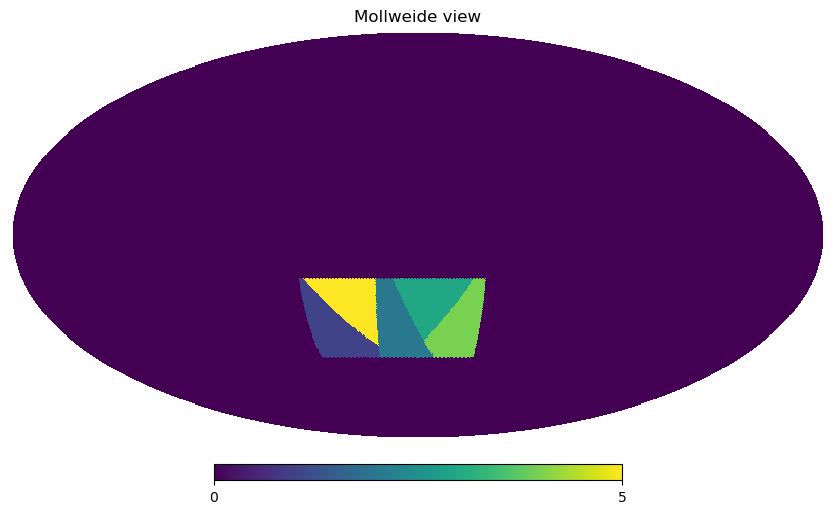

In [11]:
hp.mollview(jk_maps[("VIS", 1)])

In [12]:
cls1 = {}
for jk in range(1, Njk+1):
    _cls, _cls_mm = dices.get_delete_cls(
        data_maps,
        vis_maps,
        jk_maps,
        jk,
        jk,
    )
    # Mask correction
    _cls = dices.correct_mask(_cls, _cls_mm, mls0)

    # Bias correction
    _cls = dices.correct_bias(
        _cls,
        jk_maps,
        jk,
        jk,
    )
    cls1[(jk, jk)] = _cls

In [13]:
cqs0 = heracles.binned(cls0, ledges)
cqs1 = heracles.binned(cls1, ledges)

In [14]:
(
shrunk_delete1_cov,
delete1_cov,
target_cov,
) = dices.get_delete1_cov(
    cqs0,
    cqs1,
    shrink=False,
)

Shrinkage intensity not implemented for unbinned Cls
Shrinkage intensity = 0.0000


In [15]:
cls2 = {}
for jk in range(1, Njk+1):
    for jk2 in range(jk+1, Njk+1):
        _cls, _cls_mm = dices.get_delete_cls(
            data_maps,
            vis_maps,
            jk_maps,
            jk,
            jk2,
        )
        # Mask correction
        _cls = dices.correct_mask(_cls, _cls_mm, mls0)

        # Bias correction
        _cls = dices.correct_bias(
            _cls,
            jk_maps,
            jk,
            jk2,
        )
        cls2[(jk, jk2)] = _cls

In [16]:
cqs2 = heracles.binned(cls2, ledges)

In [17]:
delete2_correction = dices.get_delete2_correction(
    cqs0,
    cqs1,
    cqs2,
)
delete2_cov = dices.get_delete2_cov(delete1_cov, delete2_correction)

In [18]:
dices_cov = dices.get_dices_cov(cqs0, delete1_cov, delete2_cov)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/utils_cl.py:259: RuntimeWarning: divide by zero encountered in divide
  corr /= np.outer(sig, sig)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/utils_cl.py:259: RuntimeWarning: invalid value encountered in divide
  corr /= np.outer(sig, sig)
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/dices/dices.py:48: RuntimeWarning: invalid value encountered in multiply
  dices_cov = _corr2 * _corr1


In [19]:
_delete1_cov = dices.cov2spinblocks(cqs0, delete1_cov)
_dices_cov = dices.cov2spinblocks(cqs0, dices_cov)

In [20]:
_cqs1 = {}
for key in list(cqs1[(1,1)].keys()):
    _cqs = []
    for i in range(1, Njk+1):
        cq = cqs1[(i, i)][key]
        _cqs.append(cq)
    _cqs1[key] = np.array(_cqs)

_cqs2 = {}
for key in list(cqs2[(1, 2)].keys()):
    _cqs = []
    for i in range(1, Njk+1):
        for j in range(i+1, Njk+1):
            cq = cqs2[(i, j)][key]
            _cqs.append(cq)
    _cqs2[key] = np.array(_cqs)

#_cls2 = _cls1

cqs1_m = {}
cqs1_s = {}
cqs2_m = {}
cqs2_s = {}
for key in list(_cqs1.keys()):
    cqs1_m[key] = np.mean(_cqs1[key], axis=0)
    cqs1_s[key] = np.std(_cqs1[key], axis=0)
    cqs2_m[key] = np.mean(_cqs2[key], axis=0)
    cqs2_s[key] = np.std(_cqs2[key], axis=0)

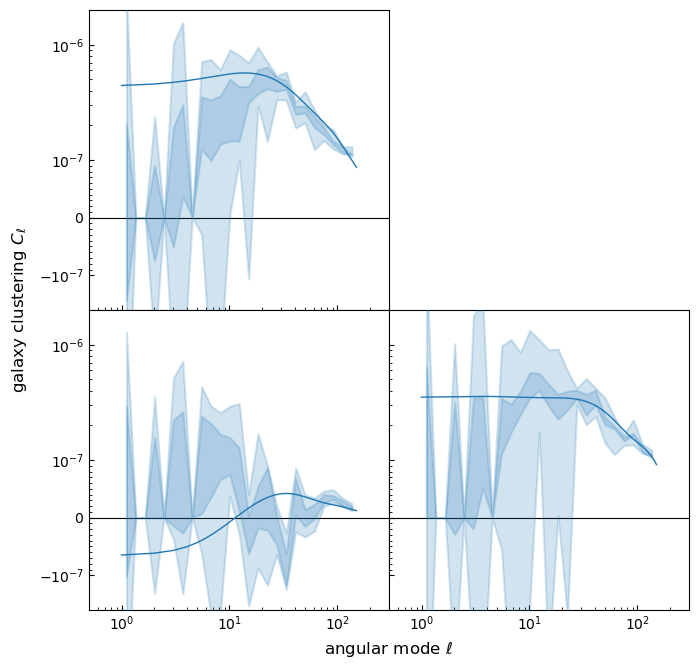

In [21]:
fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        ax[j - 1, i - 1].fill_between(
            lgrid, 
            cqs1_m["POS", "POS", i, j]-cqs1_s["POS", "POS", i, j],
            cqs1_m["POS", "POS", i, j]+cqs1_s["POS", "POS", i, j],
            color="C0", lw=1.5, zorder=3.0, alpha=0.2
        )
        ax[j - 1, i - 1].fill_between(
            lgrid, 
            cqs2_m["POS", "POS", i, j]-cqs2_s["POS", "POS", i, j],
            cqs2_m["POS", "POS", i, j]+cqs2_s["POS", "POS", i, j],
            color="C0", lw=1.5, zorder=3.0, alpha=0.2
        )
        ax[j - 1, i - 1].plot(
            ell[1:], theory["POS", "POS", i, j][1:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1/2, 2*lmax )
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-2e-7, 2e-6)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

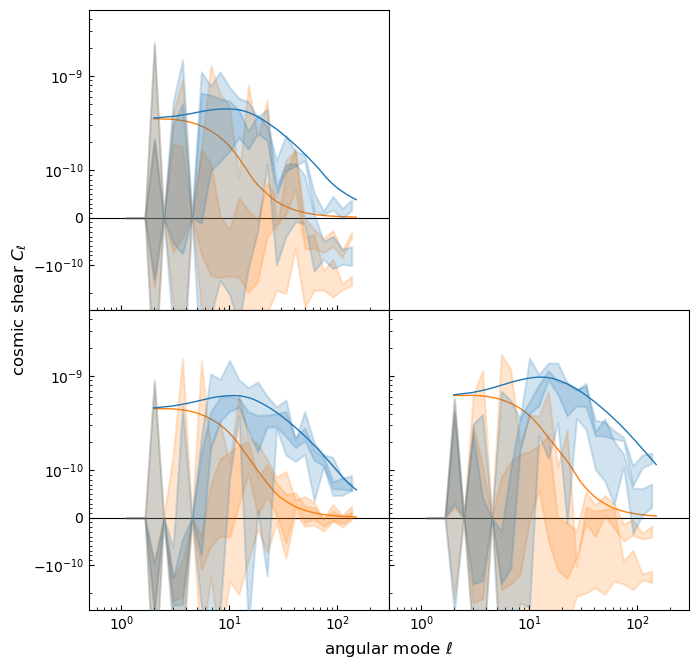

In [22]:
fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs1_m["SHE", "SHE", i, j][0, :]-cqs1_s["SHE", "SHE", i, j][0, :],
            cqs1_m["SHE", "SHE", i, j][0, :]+cqs1_s["SHE", "SHE", i, j][0, :],
            color="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs2_m["SHE", "SHE", i, j][0, :]-cqs2_s["SHE", "SHE", i, j][0, :],
            cqs2_m["SHE", "SHE", i, j][0, :]+cqs2_s["SHE", "SHE", i, j][0, :],
            color="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["SHE", "SHE", i, j][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs1_m["SHE", "SHE", i, j][1, :]-cqs1_s["SHE", "SHE", i, j][1, :],
            cqs1_m["SHE", "SHE", i, j][1, :]+cqs1_s["SHE", "SHE", i, j][1, :],
            color="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs2_m["SHE", "SHE", i, j][1, :]-cqs2_s["SHE", "SHE", i, j][1, :],
            cqs2_m["SHE", "SHE", i, j][1, :]+cqs2_s["SHE", "SHE", i, j][1, :],
            color="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["SHE", "SHE", i, j][1, 2:], c="C1", lw=1.0, zorder=2.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1/2, 2*lmax)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3e-10, 5e-9)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

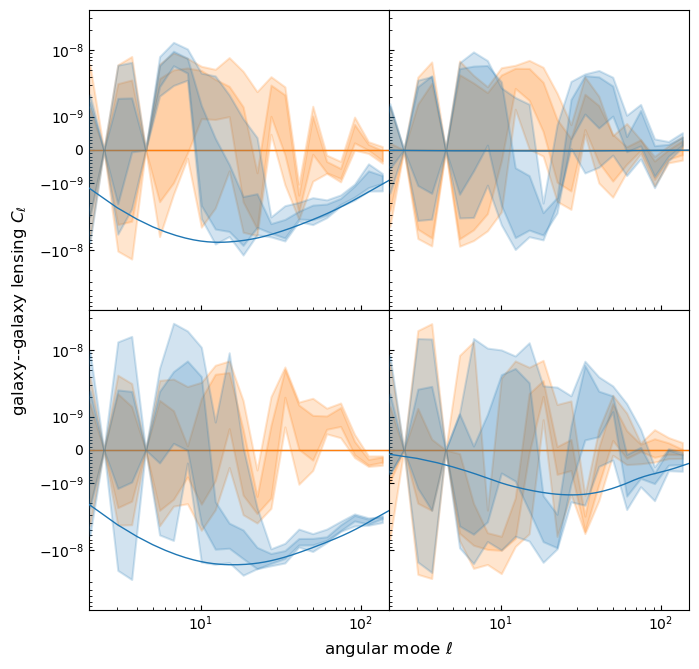

In [23]:
fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs1_m["POS", "SHE", i, j][0, :]+cqs1_s["POS", "SHE", i, j][0, :],
            cqs1_m["POS", "SHE", i, j][0, :]-cqs1_s["POS", "SHE", i, j][0, :],
            color="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs2_m["POS", "SHE", i, j][0, :]+cqs2_s["POS", "SHE", i, j][0, :],
            cqs2_m["POS", "SHE", i, j][0, :]-cqs2_s["POS", "SHE", i, j][0, :],
            color="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["POS", "SHE", i, j][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs1_m["POS", "SHE", i, j][1, :]+cqs1_s["POS", "SHE", i, j][1, :],
            cqs1_m["POS", "SHE", i, j][1, :]-cqs1_s["POS", "SHE", i, j][1, :],
            color="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].fill_between(
            lgrid,
            cqs2_m["POS", "SHE", i, j][1, :]+cqs2_s["POS", "SHE", i, j][1, :],
            cqs2_m["POS", "SHE", i, j][1, :]-cqs2_s["POS", "SHE", i, j][1, :],
            color="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.2,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["POS", "SHE", i, j][1, 2:], c="C1", lw=1.0, zorder=2.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(2, lmax)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-8e-8, 4e-8)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()

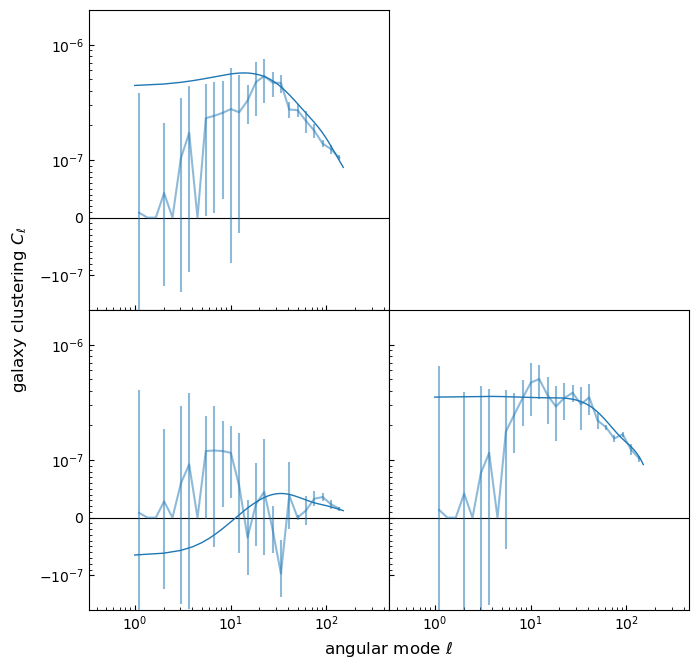

In [24]:
fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        cov_key = ("POS", "POS", "POS", "POS", i, j, i, j)
        c = _dices_cov[cov_key][0, 0, :, :]
        err = np.sqrt(np.diag(c))
        ax[j - 1, i - 1].errorbar(
            lgrid, cqs0[key], yerr=err,
            c="C0", lw=1.5, zorder=3.0, alpha=0.5
        )
        ax[j - 1, i - 1].plot(
            ell[1:], theory[key][1:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-2e-7, 2e-6)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

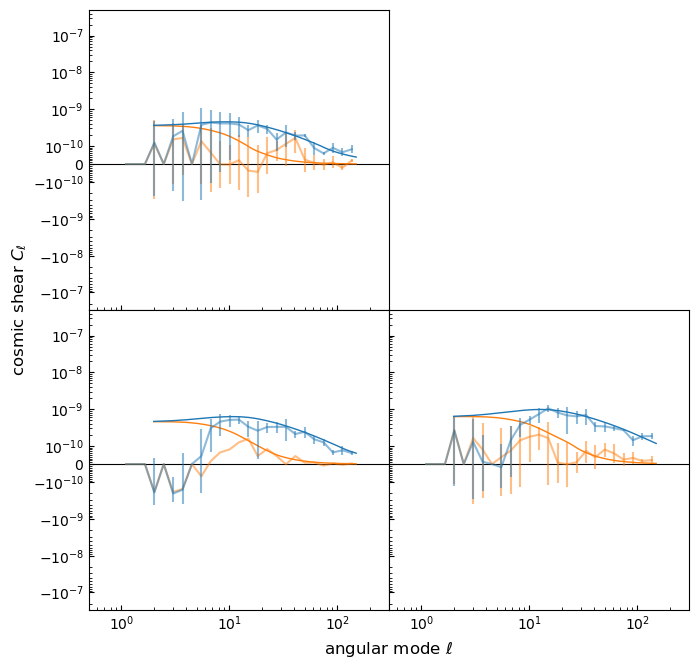

In [25]:
fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        cov_key = ("SHE", "SHE", "SHE", "SHE", i, j, i, j)
        e_c = _delete1_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _delete1_cov[cov_key][1, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[j - 1, i - 1].errorbar(
            lgrid,
            cqs0[key][0, :], yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory[key][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].errorbar(
            lgrid,
            cqs0[key][1, :], yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], 
            theory[key][1, 2:], c="C1", lw=1.0, zorder=2.0,
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1/2, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3e-7, 5e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

In [26]:
cov_key = ("POS", "SHE", "POS", "SHE", i, j, i, j)
_dices_cov[cov_key].shape

(2, 2, 25, 25)

/tmp/ipykernel_165391/115268998.py:10: RuntimeWarning: invalid value encountered in sqrt
  b_err = np.sqrt(np.diag(b_c))


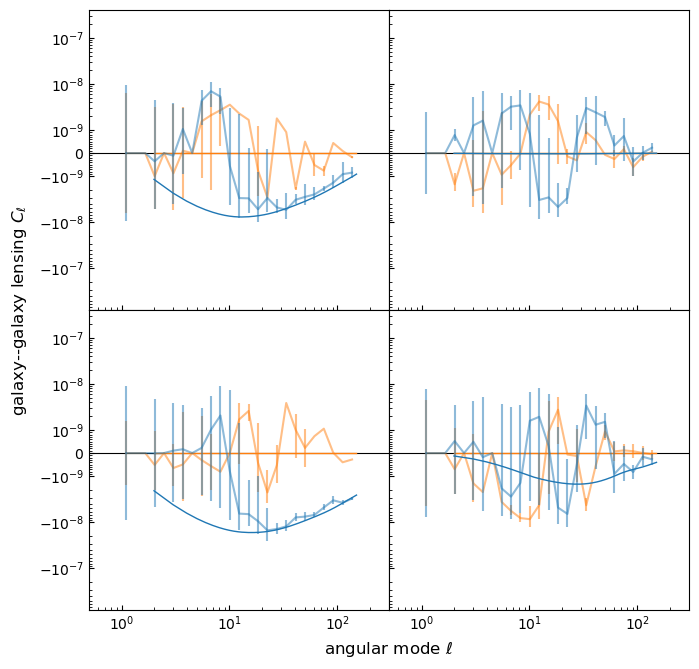

In [27]:
fig, ax = plt.subplots(nbins-1, nbins-1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "SHE", i, j)
        cov_key = ("POS", "SHE", "POS", "SHE", i, j, i, j)
        e_c = _dices_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _dices_cov[cov_key][0, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[j - 1, i - 1].errorbar(
            lgrid,
            cqs0[key][0, :],
            yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["POS", "SHE", i, j][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].errorbar(
            lgrid,
            cqs0[key][1, :],
            yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["POS", "SHE", i, j][1, 2:], c="C1", lw=1.0, zorder=2.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 2, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-8e-7, 4e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()